In [1]:
from Initialization import *

c:\libs\pycqed_py3\data
Data directory set to: c:\libs\pycqed_py3\data
c:\libs\pycqed_py3\data
Connected to: Agilent Technologies N5183B (serial:MY53271678, firmware:B.01.60) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/101645, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: SONY/TEK AWG520 (serial:0, firmware:SCPI:95.0 OS:1.0 USR:1.3a) in 0.11s


C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning:

ask is deprecated and will be removed in 1.10, use query instead.

c:\libs\qcodes\qcodes\instrument\parameter.py:247: UserWarning:

Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.

Snapshot: Could not update parameter: clock_source on ATS
Snapshot: Could not update parameter: sample_rate on ATS
Snapshot: Could not update parameter: clock_edge on ATS
Snapshot: Could not update parameter: decimation on ATS
Snapshot: Could not update parameter: coupling1 on ATS
Snapshot: Could not update parameter: channel_range1 on ATS
Snapshot: Could not update parameter: impedance1 on ATS
Snapshot: Could not update parameter: bwlimit1 on ATS
Snapshot: Could not update parameter: coupling2 on ATS
Snapshot: Could not update parameter: channel_range2 on ATS
Snapshot: Could not update parameter: impedance2 on ATS
Snapshot: C

controller initialized


In [2]:
station.components

{'RFLO': <N51x1: RFLO>,
 'SPEC': <RohdeSchwarz_SGS100A: SPEC>,
 'AWG': <Tektronix_AWG520: AWG>,
 'ATS': <AlazarTech_ATS9870: ATS>,
 'ATS_controller': <Demodulation_AcquisitionController: ATS_controller>,
 'HS': <HeterodyneInstrument: HS>,
 'MC': <MeasurementControl: MC>}

In [3]:
ATS.config(clock_source='INTERNAL_CLOCK',
                sample_rate=1e9,
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],   
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='AC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0
)

In [12]:
# configure the ATS controller
ATS_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=4096*1,
                 records_per_buffer=4000,#70, segmments
                 buffers_per_acquisition=5,
                 channel_selection='AB',
                 transfer_offset=0,
                 external_startcapture='ENABLED',
                 enable_record_headers='DISABLED',
                 alloc_buffers='DISABLED',
                 fifo_only_streaming='DISABLED',
                 interleave_samples='DISABLED',
                 get_processed_data='DISABLED',
                 allocated_buffers=5,  
                 buffer_timeout=5000,
)

In [5]:
def ATS_homodyne_acquisition(integration_start, integration_time):
    
    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.allocated_buffers()

#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
    average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.
    
    offset_I = np.average(average_record_I[3000:4000])
    offset_Q = np.average(average_record_Q[3000:4000])
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
#     integrated_output_I = np.average(average_record_I[integration_start:integration_end])#/range_I
#     integrated_output_Q = np.average(average_record_Q[integration_start:integration_end])#/range_Q
    
    
    integrated_output_I = np.average(average_record_I[integration_start:integration_end]-offset_I)#/range_I
    integrated_output_Q = np.average(average_record_Q[integration_start:integration_end]-offset_Q)#/range_Q
    
    return [integrated_output_I, integrated_output_Q, offset_I, offset_Q]

[-0.21280800000000849,
 -0.26950999999999747,
 -122.74699199999999,
 -47.177798000000003]

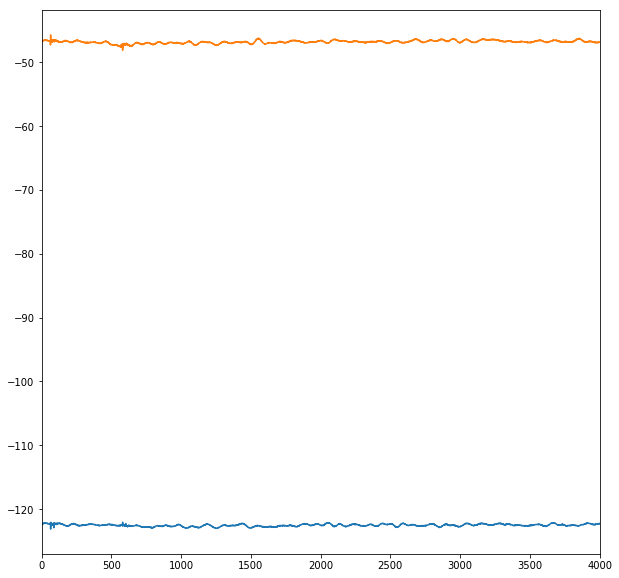

In [6]:
integration_start=800
integration_end=integration_start+500
AWG.set_sequence('rabi_sequence_FILE.seq')
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
RFLO.frequency(6.158e9)
SPEC.frequency(5.2737e9+0.05e9)  
SPEC.power(10)
RFLO.power(13)
RFLO.on()
SPEC.off()
SPEC.IQ_state.set('ON')
ATS.external_trigger_coupling._set_updated()
ATS.external_trigger_range._set_updated()

ATS_controller.pre_acquire()
blub = ATS_controller.do_acquisition()
ATS_controller.post_acquire()

buffer = ATS_controller.buffer
reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(),ATS.samples_per_record())/ATS.allocated_buffers()

# reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.allocated_buffers()-128.

# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_b uffer.flatten())[:50]])

average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.

# integrated_output_power = np.average((average_record_I[integration_start:integration_end]
#                                      +average_record_Q[integration_start:integration_end])**2)
# integrated_output_power = np.average(((average_record_I[integration_start:integration_end])**2
#                                      +(average_record_Q[integration_start:integration_end])**2))**0.5


plt.figure(figsize=(10,10))
plt.plot(average_record_I)
plt.plot(average_record_Q)
# plt.plot((average_record_Q**2+average_record_I**2)**0.5)
plt.xlim(0,4000)
ATS_homodyne_acquisition(800,500)

# Pulse spectroscopy - single

In [7]:
import stlab
import stlabutils

None
B2_2019_06_03_07.05.47_Pulse_spec_-10dBm
B2_2019_06_03_07.05.47_Pulse_spec_-10dBm\B2_2019_06_03_07.05.47_Pulse_spec_-10dBm.dat
Measurement Name:  B2_2019_06_03_07.05.47_Pulse_spec_-10dBm
metagen.fromarrays: Warning, equal values for ymin and ymax. Correcting


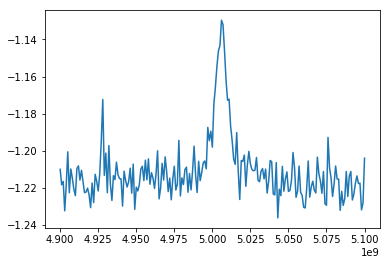

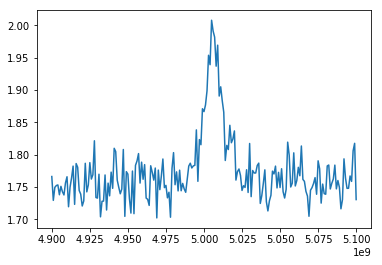

In [9]:
prefix = 'B'
idstring = 'Pulse_spec'
myfile = stlab.newfile(prefix, idstring, autoindex=True)

AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(5.00e9-0.1e9, 5.00e9+0.1e+9,201)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
integrated_output = []
SPEC.power.set(-10)
RFLO.power(16.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(3.748e9)  
avg=5

for ii in range(0,avg):
    for i, frequency in enumerate(spec_frequencies):
        SPEC.frequency.set(frequency+0.05e9)
        integrated_output.append(ATS_homodyne_acquisition(750,500))
#     print(frequency)

integrated_output = np.array(integrated_output)

data_I =np.mean(integrated_output[:,0].reshape(avg,201),axis=0)
data_Q =np.mean(integrated_output[:,1].reshape(avg,201),axis=0)

plt.figure()
plt.plot(spec_frequencies, data_I)
plt.figure()
plt.plot(spec_frequencies, data_Q)   

data = pd.DataFrame({'freq (Hz)':spec_frequencies,'I ()':data_I,'Q ()': data_Q, 
                     'AWG_ch1_amp' : AWG.ch1_amp(), 'AWG_ch2_amp':AWG.ch2_amp(), 'SPEC':SPEC.power(), 'RF_freq' : RFLO.frequency(), 
                     'RF_power':RFLO.power(),'Number of avg':avg,'record_per_buffer':ATS.records_per_buffer(),
                     'allocated_buffer':ATS.allocated_buffers()})
# data['Frequency (Hz)']=spec_frequencies
stlabutils.saveframe(myfile,data)  #Save measured data to file.  Written as a block for spyview.
#Create metafile for spyview at each measurement step
stlabutils.metagen.fromarrays(
    myfile,
    data['freq (Hz)'],
    [0],
    xtitle='freq (Hz)',
    ytitle='Homodyne voltage (arb. unit)',
    colnames=list(data))
myfile.close()
  

# Quick analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

f=spec_frequencies
f0=spec_frequencies

foldername = ''
filepath = foldername+'/'+foldername+'.dat'
mydata = stlabutils.readdata.readdat(filepath)
ii = 0
block = mydata[ii]
yi=block['I ()']
yq=block['Q ()']

gmodel = lorentzian()
result_i = gmodel.fit(yi,x=f,amp=-1e4, gamma=1e+3, x0=3.04785e+9,offset=-50)
result_q = gmodel.fit(yq,x=f,amp=-1e4, gamma=1e+3, x0=3.04785e+9,offset=-50)

print(result_i.fit_report())
print(result_q.fit_report())
 
plt.figure()
plt.plot(f, yi, 'bo')
plt.plot(f0, decay(f0,result_i.best_values['amp'],result_i.best_values['T1'],result_i.best_values['offset']), 'r-')
plt.xlim(0, 8.6e-6)
plt.title('T1' )
plt.xlabel('time delay s')
plt.ylabel('Homodyne voltage (a.u.)')
plt.savefig(foldername+'/'+str(ii)+'_spectroscopy_fit_I.png', dpi=200)

plt.figure()
plt.plot(f, yq, 'bo')
plt.plot(f0, decay(f0,result_q.best_values['amp'],result_q.best_values['T1'],result_q.best_values['offset']), 'r-')
plt.xlim(0, 8.6e-6) 
plt.title('T1' )
plt.xlabel('time delay us')
plt.ylabel('Homodyne voltage (a.u.)')
plt.savefig(foldername+'/'+str(ii)+'_spectroscopy_fit_Q.png', dpi=200)

#  Pulse spectroscopy - power sweep

In [ ]:
prefix = 'B'
idstring = 'Pulse_spec-avg_5-1000records-singlebuffer'
myfile = stlab.newfile(prefix, idstring, autoindex=True)

AWG.set_sequence('pulsed_spec_sequence_FILE.seq')
spec_frequencies = np.linspace(5.00e9-0.1e9, 5.00e9+0.1e+9,201)
powers=np.linspace(-10,0,11)
AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
RFLO.power(13.0)
SPEC.IQ_state.set('ON')  
SPEC.on()     
RFLO.frequency.set(3.748e9)  
avg=5

for iii, power in enumerate(powers):
    SPEC.power.set(power)
    integrated_output = []
    for ii in range(0,avg):
        for i, frequency in enumerate(spec_frequencies):
            SPEC.frequency.set(frequency+0.05e9)
            integrated_output.append(ATS_homodyne_acquisition(700,1000))
    integrated_output = np.array(integrated_output)
    data_I =np.mean(integrated_output[:,0].reshape(avg,101),axis=0)
    data_Q =np.mean(integrated_output[:,1].reshape(avg,101),axis=0)
    data = pd.DataFrame({'freq (Hz)':spec_frequencies,'I ()':data_I,'Q ()': data_Q, 'RF_freq' : RFLO.frequency() ,'RF_power':RFLO.power()})
    data['Power (dBm)']=power
    stlabutils.saveframe(myfile,data) 
    stlabutils.metagen.fromarrays(
    myfile,
    data['freq (Hz)'],
    powers[0:iii+1],
    xtitle='freq (Hz)',
    ytitle='Power (dBm)',
    colnames=list(data))
myfile.close()
  

# Single element Rabi

None
B5_2019_06_03_11.15.45_Rabi
B5_2019_06_03_11.15.45_Rabi\B5_2019_06_03_11.15.45_Rabi.dat
Measurement Name:  B5_2019_06_03_11.15.45_Rabi
metagen.fromarrays: Warning, equal values for ymin and ymax. Correcting


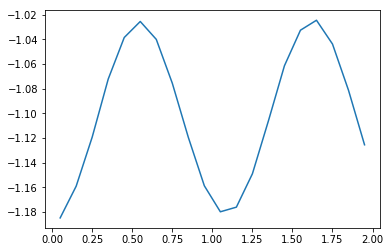

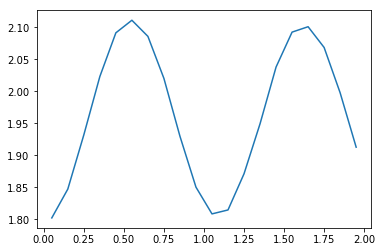

In [19]:
prefix = 'B'
idstring = 'Rabi'
myfile = stlab.newfile(prefix, idstring, autoindex=True)

amps = np.arange(0.05,2.0,0.1)
steps=len(amps)
rabi_integrated_output = []
SPEC.power.set(0.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(5.005e9+0.05e9)
RFLO.on()
RFLO.power(16.0)
RFLO.frequency.set(3.748e9)  
avg=50
for ii in range(0,avg):
    for i, amp in enumerate(amps):
        ATS.clear_buffers()
        AWG.ch1_amp(amp)
        AWG.ch2_amp(amp)
        rabi_integrated_output.append(ATS_homodyne_acquisition(750,500))
rabi_integrated_output = np.array(rabi_integrated_output)
data_I =np.mean(rabi_integrated_output[:,0].reshape(avg,steps),axis=0)
data_Q =np.mean(rabi_integrated_output[:,1].reshape(avg,steps),axis=0)

plt.figure()
plt.plot(amps, data_I)
plt.figure()
plt.plot(amps, data_Q) 

data = pd.DataFrame({'freq (Hz)':spec_frequencies,'I ()':data_I,'Q ()': data_Q, 
                     'SPEC':SPEC.power(),'SPEC_freq' : SPEC.frequency(),'RF_freq' : RFLO.frequency(), 
                     'RF_power':RFLO.power(),'Number of avg':avg,'record_per_buffer':ATS.records_per_buffer(),
                     'allocated_buffer':ATS.allocated_buffers()})stlabutils.saveframe(myfile,data)
stlabutils.metagen.fromarrays(
    myfile,
    data['AWG Amp (a.u.)'],
    [0],
    xtitle='AWG Amp (a.u.)',
    ytitle='Homodyne voltage (arb. unit)',
    colnames=list(data))
myfile.close()
print('Measurement finished!')


# Single element Rabi - quick analysis

In [ ]:
from lmfit import Model 
def Rabi(x,amp,omega,offset):
    return amp*np.cos(2*np.pi*x/omega)+offset

yi=data_I
yq=data_Q

f=amps
f0=np.arange(0.05,2.0,0.01)

foldername = ''
filepath = foldername+'/'+foldername+'.dat'
mydata = stlabutils.readdata.readdat(filepath)
ii = 0
block = mydata[ii]
yi=block['I ()']
yq=block['Q ()']

gmodel = Model(Rabi)
result_i = gmodel.fit(yi,x=f,amp=0.2,T1=3e-6,offset=0.0)
result_q = gmodel.fit(yq,x=f,amp=0.2,T1=3e-6,offset=0.0)

print(result_i.fit_report())
print(result_q.fit_report())

plt.figure()
plt.plot(f, yi, 'bo')
plt.plot(f0, Rabi(f0,result1.best_values['amp'],result1.best_values['omega'],result1.best_values['offset']), 'r-')
plt.title('Rabi Oscillation I')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Homodyne voltage (a.u.) ')
plt.text(1,0, r'T1=%s'%result_i.best_values['omega'], fontsize=12)
plt.savefig('Rabi_measure_I_fit.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.plot(f, yq, 'bo')
plt.plot(f0, Rabi(f0,result2.best_values['amp'],result2.best_values['omega'],result2.best_values['offset']), 'r-')
plt.title('Rabi Oscillation Q')
plt.xlabel('AWG amp (a.u.)')
plt.ylabel('Homodyne voltage (a.u.)')
plt.text(1,0, r'T1=%s'%result_q.best_values['omega'], fontsize=12)
plt.savefig('Rabi_measure_Q_fit.png', dpi=300, bbox_inches='tight')